Code to make a map of marine metatranscriptomic and metagenomic study sites using NCBI's uploaded metadata table on BigQuery: nih-sra-datastore.sra.metadata

ChatGPT used for SQL interfacing and python plotting

# SRA

In [64]:
import pandas as pd
import numpy as np
import re

df = pd.read_csv("sra_coords.csv")
df.columns = [c.strip() for c in df.columns]

lat = np.full(len(df), np.nan)
lon = np.full(len(df), np.nan)

for i, s in enumerate(df["lat_lon"].astype(str)):
    if not s or s == "nan":
        continue
    m = re.search(r'([+-]?\d+(?:\.\d+)?)\s*([NS])\s+([+-]?\d+(?:\.\d+)?)\s*([EW])', s, re.I)
    if m:
        lat[i] = float(m.group(1)) * (-1 if m.group(2).upper() == "S" else 1)
        lon[i] = float(m.group(3)) * (-1 if m.group(4).upper() == "W" else 1)
        continue
    m = re.search(r'([+-]?\d+(?:\.\d+)?)\s*[, ]\s*([+-]?\d+(?:\.\d+)?)', s)
    if m:
        lat[i] = float(m.group(1))
        lon[i] = float(m.group(2))

/var/folders/cw/g7w36k0922v035l7dvppfqg40000gn/T/ipykernel_49592/4145710252.py:5: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("sra_coords.csv")


In [65]:
lat2 = pd.to_numeric(df.get("latitude"), errors="coerce")
lon2 = pd.to_numeric(df.get("longitude"), errors="coerce")

df["lat"] = np.where(~np.isnan(lat), lat, lat2)
df["lon"] = np.where(~np.isnan(lon), lon, lon2)

df.loc[~df["lat"].between(-90, 90), "lat"] = np.nan
df.loc[~df["lon"].between(-180, 180), "lon"] = np.nan

pts = df.dropna(subset=["lat","lon"]).drop_duplicates(subset=["acc"])


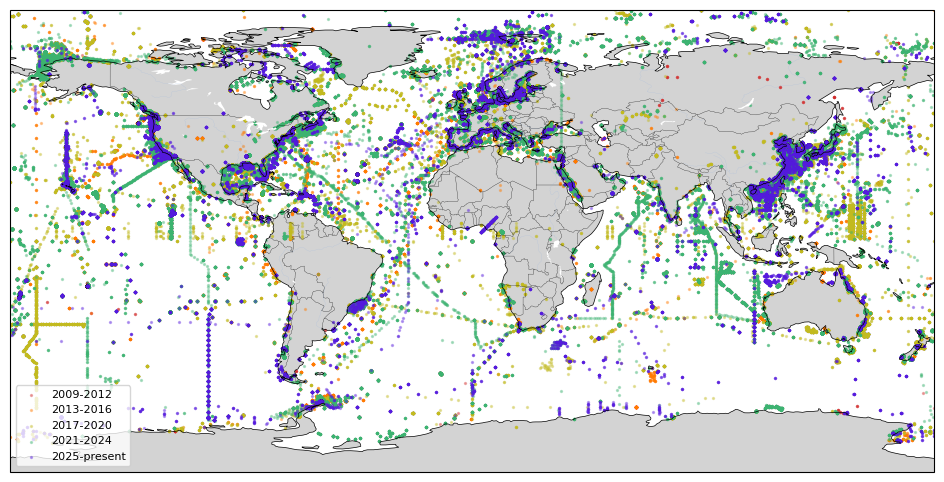

In [68]:
#Color data points by release date in SRA
df["releasedate_dt"] = pd.to_datetime(df["releasedate"], errors="coerce", utc=True)
pts["releasedate_dt"] = pd.to_datetime(pts["releasedate"], errors="coerce", utc=True)
pts["year"] = pts["releasedate_dt"].dt.year
pts["year"].describe()
bins = [2009, 2013, 2017, 2021, 2025, 2027]
labels = ["2009-2012", "2013-2016", "2017-2020", "2021-2024", "2025-present"]

pts["bucket"] = pd.cut(pts["year"], bins=bins, labels=labels, right=False)
pts["bucket"].value_counts(dropna=False)
colors = {
    "2009-2012": "#D22B2B",
    "2013-2016": "#FF7B00",
    "2017-2020": "#C2BA1F",
    "2021-2024": "#3CB371",
    "2025-present": "#551ADE",
}

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.2)
ax.add_feature(cfeature.LAKES, facecolor="white", linewidth=0.1)
ax.add_feature(cfeature.RIVERS, linewidth=0.1)

for lab in labels:
    sub = pts[pts["bucket"] == lab]
    ax.scatter(
        sub["lon"], sub["lat"],
        s=2, alpha=0.35,
        color=colors[lab],
        transform=ccrs.PlateCarree(),
        label=lab
    )

ax.set_global()
ax.set_title("")
ax.legend(loc="lower left", fontsize=8, frameon=True)
plt.show()

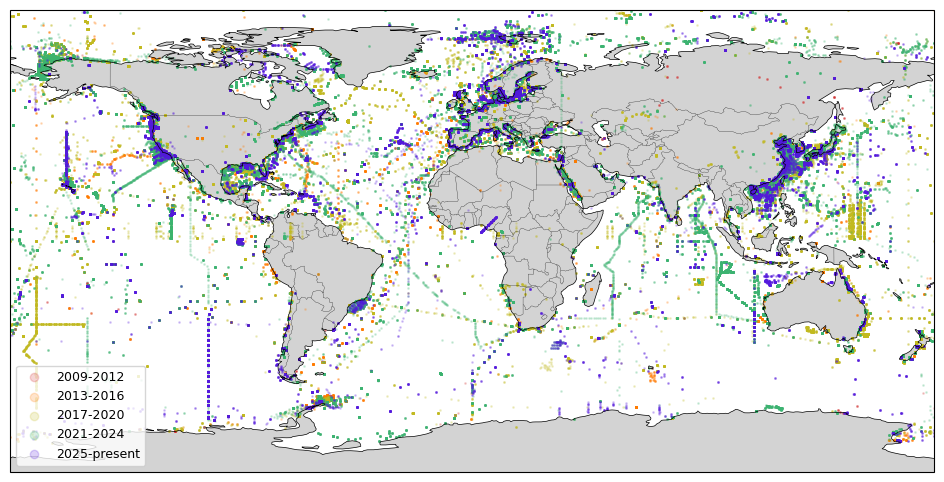

In [67]:
#Make legend larger
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.2)

for lab in labels:
    sub = pts[pts["bucket"] == lab]
    ax.scatter(
        sub["lon"], sub["lat"],
        s=1, alpha=0.2,
        color=colors[lab],
        transform=ccrs.PlateCarree(),
        label=lab
    )

ax.set_global()
ax.set_title("")

leg = ax.legend(
    loc="lower left",
    fontsize=9,
    frameon=True,
    markerscale=6   
)

plt.show()